In [36]:
import pandas as pd
data = pd.read_csv("/kaggle/input/load-forecasting-dataset/load_forecasting_dataset_corrected.csv")

In [37]:
data.head()
import numpy as np

In [38]:
display(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189888 entries, 0 to 189887
Data columns (total 15 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Timestamp                    189888 non-null  object 
 1   Temperature (°C)             189888 non-null  float64
 2   Humidity (%)                 189888 non-null  float64
 3   Wind Speed (m/s)             189888 non-null  float64
 4   Rainfall (mm)                189888 non-null  float64
 5   Solar Irradiance (W/m²)      189888 non-null  float64
 6   GDP (LKR)                    189888 non-null  float64
 7   Per Capita Energy Use (kWh)  189888 non-null  float64
 8   Electricity Price (LKR/kWh)  189888 non-null  float64
 9   Day of Week                  189888 non-null  int64  
 10  Hour of Day                  189888 non-null  int64  
 11  Month                        189888 non-null  int64  
 12  Season                       189888 non-null  object 
 13 

None

In [39]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['minute'] = df.index.minute
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['year'] = df.index.year
    df['season'] = df['month'] % 12 // 3 + 1
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week

    # Additional features
    df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)
    df['is_month_start'] = (df['dayofmonth'] == 1).astype(int)
    df['is_month_end'] = (df['dayofmonth'] == df.index.days_in_month).astype(int)
    df['is_quarter_start'] = ((df['dayofmonth'] == 1) & (df['month'] % 3 == 1)).astype(int)
    df['is_quarter_end'] = (df['dayofmonth'] == df.groupby(['year', 'quarter'])['dayofmonth'].transform('max')).astype(int)


    # Additional features
    df['is_working_day'] = df['dayofweek'].isin([0, 1, 2, 3, 4]).astype(int)
    df['is_business_hours'] = df['hour'].between(9, 17).astype(int)
    df['is_peak_hour'] = df['hour'].isin([8, 12, 18]).astype(int)

    # Minute-level features
    df['minute_of_day'] = df['hour'] * 60 + df['minute']
    df['minute_of_week'] = (df['dayofweek'] * 24 * 60) + df['minute_of_day']

    return df

In [40]:
def create_sequences(X, y, seq_len):
    Xs, ys = [], []
    for i in range(len(X) - seq_len):
        Xs.append(X[i:i+seq_len])
        ys.append(y[i+seq_len])
    return np.array(Xs), np.array(ys)

In [41]:
# Create features for the new data
if 'Timestamp' in data.columns:
    data['Timestamp'] = pd.to_datetime(data['Timestamp'])
    data = data.set_index('Timestamp')

data = create_features(data)

# Convert 'Season' to numerical using one-hot encoding
if 'Season' in data.columns:
    data = pd.get_dummies(data, columns=['Season'], prefix='season', dtype=int)
else:
    print("Warning: 'Season' column not found in the DataFrame.")


# Convert remaining columns to float
data = data.astype(float)

# Display the first few rows with new features
display(data.head())

,Temperature (°C),Humidity (%),Wind Speed (m/s),Rainfall (mm),Solar Irradiance (W/m²),GDP (LKR),Per Capita Energy Use (kWh),Electricity Price (LKR/kWh),Day of Week,Hour of Day,...,is_quarter_start,is_quarter_end,is_working_day,is_business_hours,is_peak_hour,minute_of_day,minute_of_week,season_Fall,season_Summer,season_Winter
Timestamp,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,28.993428,75.011269,1.053861,4.140513,185.892561,925.621430,502.915605,20.454440,2.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,2880.0,0.0,1.0,0.0
2020-01-01 00:15:00,27.723471,77.024015,1.085152,9.446997,281.782650,1020.823521,497.286366,27.776449,2.0,0.0,...,1.0,0.0,1.0,0.0,0.0,15.0,2895.0,0.0,1.0,0.0
2020-01-01 00:30:00,29.295377,74.732958,3.363800,4.265813,328.942058,1028.847455,488.816292,21.097420,2.0,0.0,...,1.0,0.0,1.0,0.0,0.0,30.0,2910.0,0.0,1.0,0.0
2020-01-01 00:45:00,31.046060,87.615995,2.539148,1.038103,336.407064,937.963002,468.038834,26.032137,2.0,0.0,...,1.0,0.0,1.0,0.0,0.0,45.0,2925.0,0.0,1.0,0.0
2020-01-01 01:00:00,27.531693,79.709858,1.366819,4.201393,205.494256,934.477462,488.565716,27.079114,2.0,1.0,...,1.0,0.0,1.0,0.0,0.0,60.0,2940.0,0.0,1.0,0.0


In [42]:
data = data.iloc[::96]

In [43]:
# # # # Add lag features
data["lag_1"] = data["Load Demand (kW)"].shift(1)      # 15 min ago
data["lag_4"] = data["Load Demand (kW)"].shift(4)      # 1 hour ago
# data["lag_96"] = data["Load Demand (kW)"].shift(96)    # 24 hours ago
# data["lag_672"] = data["Load Demand (kW)"].shift(672)  # 7 days ago
# extra_lags = [1,2, 3,4, 8, 12, 24, 48, 96, 192, 672]
# for l in extra_lags:
#     data[f"lag_{l}"] = data["Load Demand (kW)"].shift(l)
# Drop rows with NaN from lag creation
y = data["Load Demand (kW)"].shift(-96)
# data = data.dropna()

data = data.dropna()

In [44]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1974 entries, 2020-01-05 to 2025-05-31
Data columns (total 39 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Temperature (°C)             1974 non-null   float64
 1   Humidity (%)                 1974 non-null   float64
 2   Wind Speed (m/s)             1974 non-null   float64
 3   Rainfall (mm)                1974 non-null   float64
 4   Solar Irradiance (W/m²)      1974 non-null   float64
 5   GDP (LKR)                    1974 non-null   float64
 6   Per Capita Energy Use (kWh)  1974 non-null   float64
 7   Electricity Price (LKR/kWh)  1974 non-null   float64
 8   Day of Week                  1974 non-null   float64
 9   Hour of Day                  1974 non-null   float64
 10  Month                        1974 non-null   float64
 11  Public Event                 1974 non-null   float64
 12  Load Demand (kW)             1974 non-null   float64
 13  

In [45]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1974 entries, 2020-01-05 to 2025-05-31
Data columns (total 39 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Temperature (°C)             1974 non-null   float64
 1   Humidity (%)                 1974 non-null   float64
 2   Wind Speed (m/s)             1974 non-null   float64
 3   Rainfall (mm)                1974 non-null   float64
 4   Solar Irradiance (W/m²)      1974 non-null   float64
 5   GDP (LKR)                    1974 non-null   float64
 6   Per Capita Energy Use (kWh)  1974 non-null   float64
 7   Electricity Price (LKR/kWh)  1974 non-null   float64
 8   Day of Week                  1974 non-null   float64
 9   Hour of Day                  1974 non-null   float64
 10  Month                        1974 non-null   float64
 11  Public Event                 1974 non-null   float64
 12  Load Demand (kW)             1974 non-null   float64
 13  

In [46]:
!pip install xgboost

from sklearn.model_selection import train_test_split

In [47]:
from sklearn.model_selection import train_test_split

In [48]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# -----------------------------
# Train/Test Split (already done but reusing cleanly)
# -----------------------------
# X = data.drop("Load Demand (kW)", axis=1)
# y = data["Load Demand (kW)"]
y = data["Load Demand (kW)"].shift(-96)

# Remove rows with NaN caused by shift
data = data.iloc[:-96]

X = data.drop("Load Demand (kW)", axis=1)
y = y.iloc[:-96]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

In [49]:

model = XGBRegressor(
    n_estimators=500,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42
)

model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=50
)

y_pred = model.predict(X_test)


rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f"RMSE: {rmse:.2f}")
print(f"MAE : {mae:.2f}")
print(f"MAPE: {mape:.2f}%")

[0]	validation_0-rmse:204.74998
[50]	validation_0-rmse:209.17729
[100]	validation_0-rmse:211.65431
[150]	validation_0-rmse:212.45495
[200]	validation_0-rmse:213.44535
[250]	validation_0-rmse:213.35423
[300]	validation_0-rmse:213.45804
[350]	validation_0-rmse:213.62772
[400]	validation_0-rmse:213.68204
[450]	validation_0-rmse:213.70172
[499]	validation_0-rmse:213.70299
RMSE: 213.70
MAE : 171.55
MAPE: 11.80%


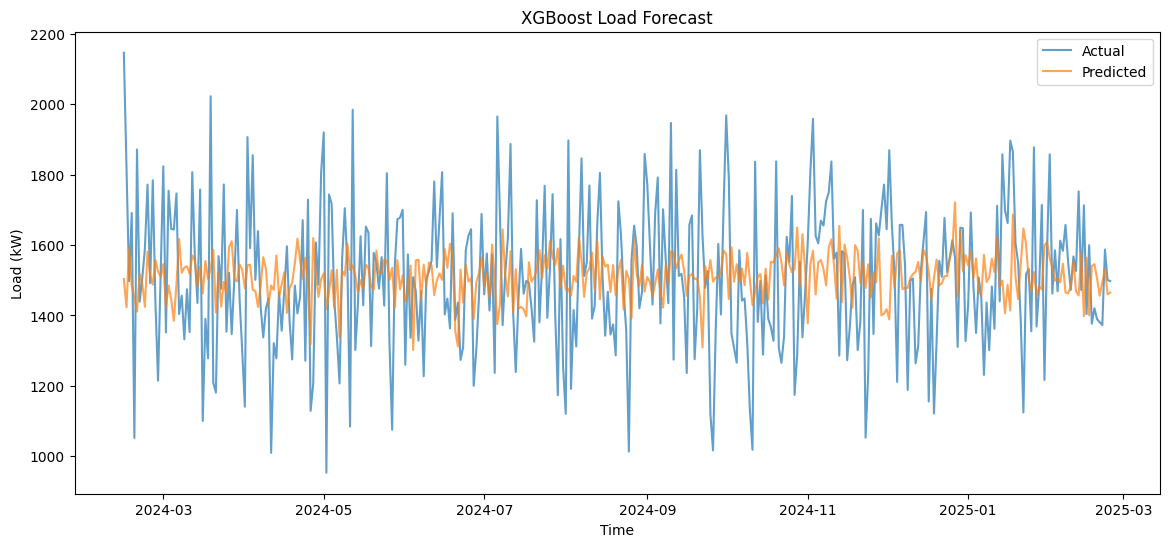

In [50]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(y_test.index, y_test.values, label="Actual", alpha=0.7)
plt.plot(y_test.index, y_pred, label="Predicted", alpha=0.7)
plt.legend()
plt.title("XGBoost Load Forecast")
plt.xlabel("Time")
plt.ylabel("Load (kW)")
plt.show()

In [51]:
import joblib

joblib.dump(model, "xgb_model.pkl")
joblib.dump(X_train.columns.tolist(), "feature_cols.pkl")

['feature_cols.pkl']

In [52]:
from sklearn.metrics import r2_score
import numpy as np


r2 = r2_score(y_test, y_pred)

print(f"R^2 Score: {r2}")

R^2 Score: -0.08849624903904219


In [53]:
# import joblib
# import pandas as pd
# import numpy as np

# # Load saved files
# loaded_model = joblib.load("/kaggle/input/train-file/load_model.pkl")
# loaded_columns = joblib.load("/kaggle/input/train-file/feature_columns.pkl")

# print("Model loaded:", loaded_model)
# print("Number of features:", len(loaded_columns))
# print("First 10 features:", loaded_columns[:10])

In [54]:
# # Take one real row from X_test
# sample_input = X_test.iloc[0:1].copy()

# # Ensure column order matches
# sample_input = sample_input.reindex(columns=loaded_columns, fill_value=0)

# # Predict using loaded model
# pred = loaded_model.predict(sample_input)

# print("Prediction:", pred[0])
# print("Actual value:", y_test.iloc[0])

In [55]:
# # Original model prediction
# original_pred = model.predict(sample_input)[0]

# # Loaded model prediction
# loaded_pred = loaded_model.predict(sample_input)[0]

# print("Original model prediction:", original_pred)
# print("Loaded model prediction:  ", loaded_pred)
# print("Difference:", abs(original_pred - loaded_pred))

In [56]:
# from sklearn.metrics import r2_score

# # R2 Score
# r2 = r2_score(y_test, y_pred)

# print(f"RMSE: {rmse:.2f}")
# print(f"MAE : {mae:.2f}")
# print(f"MAPE: {mape:.2f}%")
# print(f"R2  : {r2:.4f}")